In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from google.colab import drive

# 0. Data Loading

In [ ]:
# Mount Google Drive to access the dataset files
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/MLGroupProject'
dataset_file_path = f'{folder_path}/diabetes.csv'

#reading data file into data frame
df = pd.read_csv(dataset_file_path)
df.columns = df.columns.str.strip()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#1. Data Pre-processing

In [ ]:
# Columns that need decimal conversion
columns_with_comma_decimal = ['chol_hdl_ratio', 'bmi', 'waist_hip_ratio']
for column in columns_with_comma_decimal:
    df[column] = df[column].astype(str).str.replace(',', '.').astype(float)

# Encode the 'gender' column
df['gender'] = df['gender'].map({'male': 0, 'female': 1})

# Encode the 'diabetes' column
df['diabetes'] = df['diabetes'].map({'No diabetes': 0, 'Diabetes': 1})

# Handle Missing Values (if any)
df.fillna(df.median(), inplace=True)

**Feature Scaling**

In [ ]:
X = df.drop('diabetes', axis=1)
y = df['diabetes']

scaler = StandardScaler()

# Fit and transform the scaler on the features
X_scaled = scaler.fit_transform(X)

**Train-Test Split**

In [ ]:
'''
using stratify to split the data in such a way that the proportion of diabetes vs no diabetes cases in
both training and testing sets will match the proportion in the full dataset y.
'''
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
def assert_stratification(y, y_train, y_test):
    original_proportion = y.value_counts(normalize=True)
    train_proportion = y_train.value_counts(normalize=True)
    test_proportion = y_test.value_counts(normalize=True)

    # Assert that the difference in proportions is small
    assert (original_proportion - train_proportion).abs().max() < 0.05, "Training set stratification failed"
    assert (original_proportion - test_proportion).abs().max() < 0.05, "Testing set stratification failed"

    print("Proportion of 'diabetes' in original data: \n", original_proportion)
    print("\nProportion of 'diabetes' in training data: \n", train_proportion)
    print("\nProportion of 'diabetes' in testing data: \n", test_proportion)
    print("\nAssertion passed: The train and test sets are properly stratified.")

# Call the function to perform the check
assert_stratification(y, y_train, y_test)

Proportion of 'diabetes' in original data: 
 0    0.846154
1    0.153846
Name: diabetes, dtype: float64

Proportion of 'diabetes' in training data: 
 0    0.846154
1    0.153846
Name: diabetes, dtype: float64

Proportion of 'diabetes' in testing data: 
 0    0.846154
1    0.153846
Name: diabetes, dtype: float64

Assertion passed: The train and test sets are properly stratified.


# 2. Build the Multi-Layer Model

In [ ]:
model = Sequential([
    Dense(128, activation='tanh', input_shape=(X_train.shape[1],)),
    Dense(64, activation='tanh'),
    Dense(1, activation='sigmoid')  # Since it's a binary classification
])

**Compile Model**

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Training the model
model.fit(X_train, y_train, epochs=50, batch_size=10, validation_split=0.2)

Epoch 1/50
25/25 [==============================] - 1s 11ms/step - loss: 0.4948 - accuracy: 0.7831 - val_loss: 0.3693 - val_accuracy: 0.8889
Epoch 2/50
25/25 [==============================] - 0s 3ms/step - loss: 0.3224 - accuracy: 0.9277 - val_loss: 0.2423 - val_accuracy: 0.9206
Epoch 3/50
25/25 [==============================] - 0s 4ms/step - loss: 0.2535 - accuracy: 0.9357 - val_loss: 0.2189 - val_accuracy: 0.9206
Epoch 4/50
25/25 [==============================] - 0s 4ms/step - loss: 0.2324 - accuracy: 0.9357 - val_loss: 0.2270 - val_accuracy: 0.9206
Epoch 5/50
25/25 [==============================] - 0s 3ms/step - loss: 0.2300 - accuracy: 0.9197 - val_loss: 0.2294 - val_accuracy: 0.9206
Epoch 6/50
25/25 [==============================] - 0s 4ms/step - loss: 0.2198 - accuracy: 0.9277 - val_loss: 0.2114 - val_accuracy: 0.9206
Epoch 7/50
25/25 [==============================] - 0s 4ms/step - loss: 0.2127 - accuracy: 0.9237 - val_loss: 0.2258 - val_accuracy: 0.9206
Epoch 8/50
25/25 [=

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100}%")

3/3 [==============================] - 0s 5ms/step - loss: 0.2142 - accuracy: 0.9231
Test Accuracy: 92.30769276618958%


# 3. Visualizations

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.calibration import calibration_curve
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

3/3 [==============================] - 0s 5ms/step


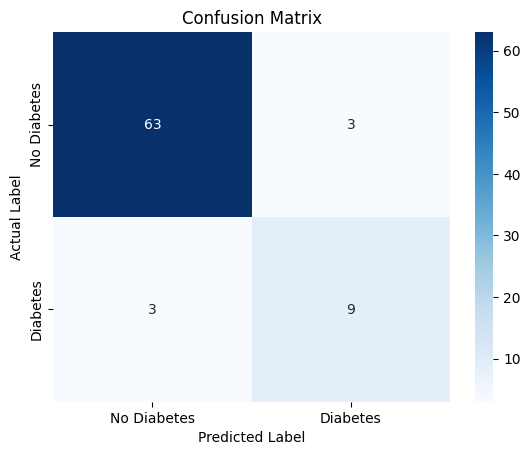

In [ ]:
# Confusion Matrix
y_pred = model.predict(X_test)
y_pred_class = np.round(y_pred).astype(int).flatten()  # Convert probabilities to class labels

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_class)
display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

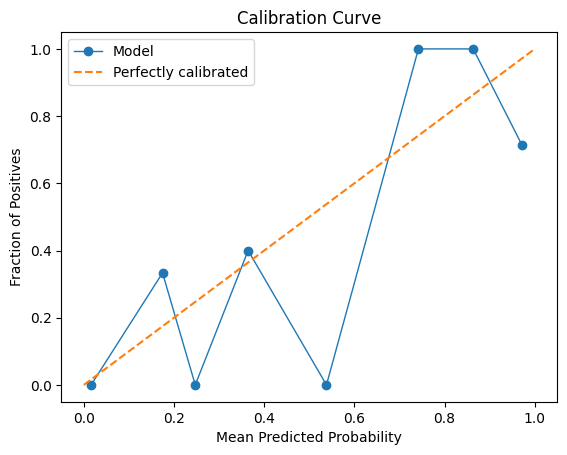

In [ ]:
# Get predicted probabilities for the positive class (e.g., 'diabetes')
y_pred_probs = y_pred.flatten()

# Compute true and predicted probabilities for calibration curve
true_prob, pred_prob = calibration_curve(y_test, y_pred_probs, n_bins=10, strategy='uniform')

# Plot the calibration curve
plt.plot(pred_prob, true_prob, marker='o', linewidth=1, label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.ylabel('Fraction of Positives')
plt.xlabel('Mean Predicted Probability')
plt.title('Calibration Curve')
plt.legend()
plt.show()